<h3>Load helper functions</h3>

In [49]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [50]:
issues = load_issues()

<h3>Load <code>all_issues</code></h3>
<p>NOTE that this includes every single issue from every single repo in the list of repos from the GK In-range breaking build issues set</p>

Count=2398438 (Project Count=12017) Median=55.0 Mean=199.58708496296913


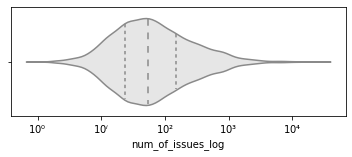

In [51]:
all_issues = load_all_issues()
counts = all_issues.groupby('repo_name')['id'].count()
print(f"Count={len(all_issues)} (Project Count={len(counts)}) Median={counts.median()} Mean={counts.mean()}")
for_plot = counts.to_frame(name='num_of_issues')
for_plot['placeholder'] = ''
for_plot['num_of_issues_log'] = np.log10(for_plot['num_of_issues'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=for_plot,
    x='num_of_issues_log',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
    logscale=True
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(log10_func_formatter)
plt.show()

<h3>Create data sets of <code>non_gk_issues</code> and <code>gk_issues</code></h3>
<p>
    For analysis, we ignore gk_issues that we dont have all issues for, and remove the duplicate gk_issues from the all_issues data set
</p>

In [52]:
def filter_issues_for_analyses(all_issues, gk_issues):
    # Make copies
    gk_issues_for_analysis = gk_issues.copy()
    non_gk_issues_for_analysis = all_issues.copy()
    # Remove pull requests from all issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['is_pull_request']
    ]
    # Filter out any issues that are GK in-range breakin gbuild issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['id'].isin(gk_issues_for_analysis['id'])
    ]
    # Only analyze GK issues for projects we have all issues for
    gk_issues_for_analysis = gk_issues_for_analysis[
        gk_issues_for_analysis['repo_name'].isin(non_gk_issues_for_analysis['repo_name'])
    ]
    # Copy the html_url and body attributes over from all_issues to their respective rows on gk_issues
    gk_issues_for_analysis = gk_issues_for_analysis.merge(
        all_issues[['id', 'html_url', 'body']],
        how='left',
        on='id',
    )
    return non_gk_issues_for_analysis, gk_issues_for_analysis
    

non_gk_issues, gk_issues = filter_issues_for_analyses(all_issues, issues)

<h3><b><i>What proportion of a projects issues are GKIRs?</i></b></h3>

--What proportion of issues in a project are GK issues?--
                      Count    Mean      STD    Min    25%    Median     75%        Max
------------------  -------  ------  -------  -----  -----  --------  ------  ---------
proportion_gk          9632   0.436    0.292      0  0.167     0.417   0.667      0.998
issue_count_gk         9632  10.774   30.134      1  2         4      10       1781
issue_count_non_gk     9632  59.534  356.212      1  2         5      21      12906

--What proportion of issues in a project are GK issues (With at least the median total number of issues)?--
                      Count     Mean      STD    Min    25%    Median     75%        Max
------------------  -------  -------  -------  -----  -----  --------  ------  ---------
proportion_gk          5003    0.362    0.322      0  0.074     0.247   0.643      0.998
issue_count_gk         5003   17.86    40.482      1  4         9      18       1781
issue_count_non_gk     5003  111.891  488.468    

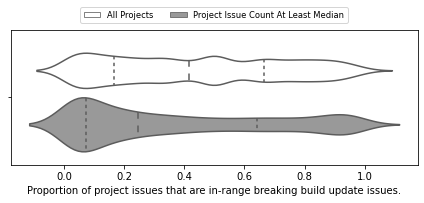

In [46]:
non_gk_issues__count = (
    non_gk_issues
        .groupby('repo_name')['id']
        .count()
        .to_frame(name='issue_count')
        .reset_index()
)
gk_issues__count = (
    gk_issues
        .groupby('repo_name')['id']
        .count()
        .to_frame(name='issue_count')
        .reset_index()
)

gk_to_non_gk_issue_counts = non_gk_issues__count.merge(
    gk_issues__count,
    on='repo_name',
    how='inner',
    suffixes=['_non_gk', '_gk'],
)
gk_to_non_gk_issue_counts['proportion_gk'] = (
    gk_to_non_gk_issue_counts['issue_count_gk'] / 
    (gk_to_non_gk_issue_counts['issue_count_gk'] + gk_to_non_gk_issue_counts['issue_count_non_gk'])
)
gk_to_non_gk_issue_counts['isue_count_total'] = gk_to_non_gk_issue_counts['issue_count_non_gk'] + gk_to_non_gk_issue_counts['issue_count_gk']

gk_to_non_gk_issue_counts['higher_than_median'] = (
    gk_to_non_gk_issue_counts['isue_count_total'] >= gk_to_non_gk_issue_counts['isue_count_total'].median()
)

for_plot = pd.DataFrame({
    'proportion_gk': gk_to_non_gk_issue_counts['proportion_gk'],
    'higher_than_median': False
})

for_plot = for_plot.append(
    pd.DataFrame({
        'proportion_gk': gk_to_non_gk_issue_counts.loc[
            gk_to_non_gk_issue_counts['higher_than_median'],
            'proportion_gk'
        ],
        'higher_than_median': True 
    })
)
for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
sns.violinplot(
    data=for_plot,
    x='proportion_gk',
    y='placeholder',
    hue='higher_than_median',
    inner='quartile',
    palette=['1', '0.6'],
)
ax.set_ylabel('')
ax.set_xlabel('Proportion of project issues that are in-range breaking build update issues.')
ax.legend(
    title='',
)
L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2
)

L.get_texts()[0].set_text('All Projects')
L.get_texts()[1].set_text('Project Issue Count At Least Median')
print('--What proportion of issues in a project are GK issues?--')
tfns(
    gk_to_non_gk_issue_counts,
    ['proportion_gk', 'issue_count_gk', 'issue_count_non_gk'],
    should_round=True
)
print('--What proportion of issues in a project are GK issues (With at least the median total number of issues)?--')
tfns(
    gk_to_non_gk_issue_counts[gk_to_non_gk_issue_counts['higher_than_median']],
    ['proportion_gk', 'issue_count_gk', 'issue_count_non_gk'],
    should_round=True
)

save_fig('projects_proportion_of_gk_issues')
plt.show()


<h3><b><i>What proportion of in-range breaking build issue reports are closed (i.e., resolved)?</i></b></h3>
<p>
    Overall, in-range breaking build issue reports are closed 79.8% of the time (20.2% are never closed).
    <br>
    When comparing at the intra-project level, the median proportion of in-range breaking build issue reports closed by individual projects is 100% (median for other issues is 0.905). Projects are closing in-range breaking build issue reports at the same rate as other issues in the project (median ratio for gk to non-gk is 1.022).
</p>

In [999]:
proportions = (
    gk_issues['state'].value_counts() / 
    gk_issues['state'].count()
).to_frame(name='proportion')\
    .rename_axis('state')\
    .reset_index()
print('--All GK in-range breaking issue state proportions (not calculated per project)--')
proportions.head()

--All GK in-range breaking issue state proportions (not calculated per project)--


,state,proportion
0,closed,0.822751
1,open,0.177249


Saving figure projects_proportion_of_closed_gk_and_non_gk_issues
--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--
Proportion of closed issues      Count    Mean    STD    Min    25%    Median    75%    Max
-----------------------------  -------  ------  -----  -----  -----  --------  -----  -----
proportion_non_gk                 7290   0.826  0.209  0.026    0.7     0.905  1          1
proportion_gk                     7290   0.909  0.211  0.022    1       1      1          1
ratio                             7290   1.224  0.729  0.022    1       1.022  1.321     19



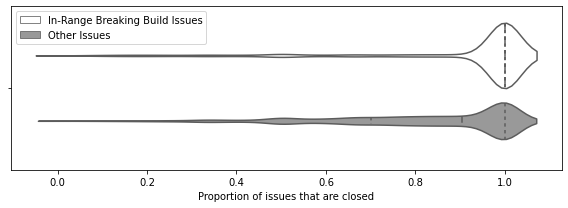

	Mann-Whitney: statistic=17380989.0 pvalue=0.0
	Cliff'a Delta: delta=0.34589205575030907 size=medium
    


In [1003]:
non_gk_issues__state_proportions = (
    (
        non_gk_issues.groupby('repo_name', observed=True)['state'].value_counts() / 
        non_gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)
gk_issues__state_proportions = (
    (
        gk_issues.groupby('repo_name')['state'].value_counts() / 
        gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)

project_issue__state_proportions = non_gk_issues__state_proportions.merge(
    gk_issues__state_proportions,
    how='inner',
    on=['repo_name', 'state'],
    suffixes=['_non_gk', '_gk'],
)
project_issue__state_proportions['ratio'] = project_issue__state_proportions['proportion_gk'] / project_issue__state_proportions['proportion_non_gk']
project_issue__state_proportions__closed = project_issue__state_proportions[project_issue__state_proportions['state'] == 'closed']

melted = pd.melt(
    project_issue__state_proportions__closed,
    id_vars='repo_name',
    value_vars=['proportion_gk', 'proportion_non_gk'],
    var_name='proportion_type',
    value_name='proportion',
)
melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='proportion',
    y='placeholder',
    hue='proportion_type',
    split=False,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Proportion of issues that are closed')
# ax.set_xlim(0, 1)
ax.legend(
    title='',
)
L = plt.legend(loc=2)

L.get_texts()[0].set_text('In-Range Breaking Build Issues')
L.get_texts()[1].set_text('Other Issues')
save_fig('projects_proportion_of_closed_gk_and_non_gk_issues')
print('--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--')
tfns(project_issue__state_proportions__closed, ['proportion_non_gk', 'proportion_gk', 'ratio'], title='Proportion of closed issues')
plt.show()

mannwhitneyu_cliffsdelta(
    project_issue__state_proportions__closed['proportion_gk'],
    project_issue__state_proportions__closed['proportion_non_gk']
)

<h4>Project ratio between proportion of closed non-gk issues and gk issues</h4>

Saving figure projects_proportion_of_closed_gk_and_non_gk_issues_high_gk_count
--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--
Proportion of closed issues      Count    Mean    STD    Min    25%    Median    75%    Max
-----------------------------  -------  ------  -----  -----  -----  --------  -----  -----
proportion_non_gk                 4453   0.818  0.209  0.026  0.694     0.888  1          1
proportion_gk                     4453   0.878  0.24   0.022  0.889     1      1          1
ratio                             4453   1.193  0.764  0.022  1         1.031  1.286     19



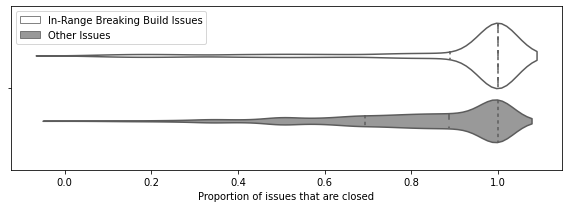

	Mann-Whitney: statistic=6949757.0 pvalue=3.1988694444249047e-155
	Cliff'a Delta: delta=0.29903840339773513 size=small
    


In [1004]:
projects_with_high_gk_counts = (
    gk_to_non_gk_issue_counts[
        gk_to_non_gk_issue_counts['issue_count_gk'] >= gk_to_non_gk_issue_counts['issue_count_gk'].median()
    ]['repo_name'].copy().reset_index(drop=True)
)

project_issue_with_high_gk_counts__state_proportions = (
    project_issue__state_proportions[
        project_issue__state_proportions['repo_name'].isin(projects_with_high_gk_counts)
    ]
)
project_issue__state_proportions__closed = (
    project_issue_with_high_gk_counts__state_proportions[
        project_issue_with_high_gk_counts__state_proportions['state'] == 'closed'
    ]
)

melted = pd.melt(
    project_issue__state_proportions__closed,
    id_vars='repo_name',
    value_vars=['proportion_gk', 'proportion_non_gk'],
    var_name='proportion_type',
    value_name='proportion',
)
melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='proportion',
    y='placeholder',
    hue='proportion_type',
    split=False,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Proportion of issues that are closed')
# ax.set_xlim(0, 1)
ax.legend(
    title='',
)
L = plt.legend(loc=2)

L.get_texts()[0].set_text('In-Range Breaking Build Issues')
L.get_texts()[1].set_text('Other Issues')
save_fig('projects_proportion_of_closed_gk_and_non_gk_issues_high_gk_count')
print('--Intra-project comparison for proportion of closed non-GKIRs & GKIRs--')
tfns(project_issue__state_proportions__closed, ['proportion_non_gk', 'proportion_gk', 'ratio'], title='Proportion of closed issues')
plt.show()


mannwhitneyu_cliffsdelta(
    project_issue__state_proportions__closed['proportion_gk'],
    project_issue__state_proportions__closed['proportion_non_gk']
)


<h4>Project ratio between proportion of closed non-gk issues and gk issues</h4>

--Intra-project comparison for ratio of a projects proportion of closed GK issues to proportion of closed non-gk issues--
         Count    Mean    STD    Min    25%    Median    75%    Max
-----  -------  ------  -----  -----  -----  --------  -----  -----
ratio     7290   1.224  0.729  0.022      1     1.022  1.321     19



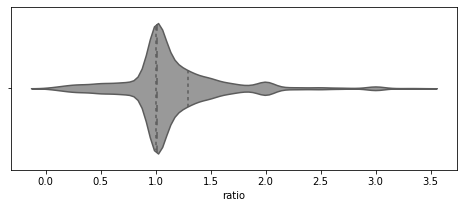

In [664]:
for_plot = project_issue__state_proportions__closed[['ratio']].copy()
for_plot = filter_outliers(for_plot, col='ratio', threshold=3)
for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
ax = sns.violinplot(
    data=for_plot,
    x='ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
    scale='width'
)
ax.set_ylabel('')
# ax.set_xlim(0, 2)
print('--Intra-project comparison for ratio of a projects proportion of closed GK issues to proportion of closed non-gk issues--')
tfns(project_issue__state_proportions__closed, ['ratio'])
plt.show()

<h3><b><i>How long does it take for in-range breaking build issue reports to be closed (i.e., resolved)?</i></b></h3>
<ul>
    <li>Overall, in-range breaking build issue reports are closed in a median of 4 days 11 hours.</li>
    <li>When comparing at the intra-project level, the median time to close in-range breaking build issues is 13 days 21 hours, while the median time to close other issues is 6 days 6 hours.</li>
    <li>At the project level, in-range breaking build issue reports stay open with a medain value of 1.575x as long as other issues.</li>
</ul>

--All GK in-range breaking issue state proportions (not calculated per project)--
                 Count  Mean              STD               Min              25%              Median           75%               Max
-------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
time_to_close    98341  43 days 04:48:29  98 days 22:44:48  0 days 00:00:04  0 days 09:58:19  4 days 11:04:25  35 days 07:48:16  1219 days 02:01:10



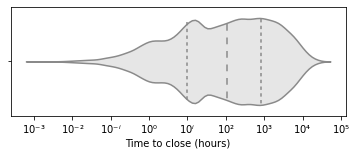

In [665]:
closed_issues = issues[issues['state'] == 'closed'][['created_at', 'closed_at']]
closed_issues['time_to_close'] = closed_issues['closed_at'] - closed_issues['created_at']
closed_issues['time_to_close_hours'] = closed_issues['time_to_close'] / np.timedelta64(1, 'h')
closed_issues['log_time_to_close_hours'] = np.log10(closed_issues['time_to_close_hours'])
closed_issues['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=closed_issues,
    x='log_time_to_close_hours',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
)
ax.set_ylabel('')
ax.set_xlabel('Time to close (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
print('--All GK in-range breaking issue state proportions (not calculated per project)--')
tfns(closed_issues, ['time_to_close'])
plt.show()

/home/local/SAIL/benjamin/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--
Median time to close issue      Count  Mean              STD                Min              25%              Median            75%               Max
----------------------------  -------  ----------------  -----------------  ---------------  ---------------  ----------------  ----------------  ------------------
median_non_gk                    7290  49 days 00:04:46  127 days 16:11:47  0 days 00:00:03  1 days 04:16:50  6 days 05:58:38   28 days 19:27:22  2097 days 11:47:18
median_gk                        7290  61 days 16:10:13  118 days 16:37:48  0 days 00:00:28  1 days 16:16:38  13 days 17:56:34  63 days 07:50:48  1130 days 03:37:18

Saving figure intra_project_median_time_to_close


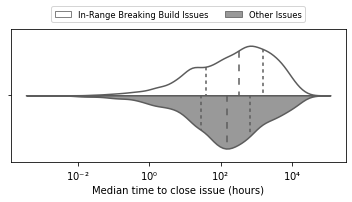

	Mann-Whitney: statistic=22914848.5 pvalue=2.9085825020758275e-47
	Cliff'a Delta: delta=0.1376333967458288 size=negligible
    


In [55]:
# Calculate mean and median intra-project time_to_close for Non-GK issues
non_gk_issues__closed = non_gk_issues[non_gk_issues['state'] == 'closed'].copy()
non_gk_issues__closed['time_to_close'] = (
    (non_gk_issues__closed['closed_at'] - non_gk_issues__closed['created_at'])
        .dt
        .total_seconds()  # Have to convert to seconds to calculate mean and median
)
project__non_gk_issue__time_to_close = (
    non_gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
        .dropna()
)
project__non_gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['mean'],
    unit='s'
)
project__non_gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__non_gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['median'],
    unit='s'
)
project__non_gk_issue__time_to_close['median_hours'] = (
    project__non_gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)
project__non_gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['median_hours']
)

# Calculate mean and median intra-project time_to_close for GK issues
gk_issues__closed = gk_issues[gk_issues['state'] == 'closed'].copy()
gk_issues__closed['time_to_close'] = (
    gk_issues__closed['closed_at'] - gk_issues__closed['created_at']
).dt.total_seconds()  # Have to convert to seconds to calculate mean and median
project__gk_issue__time_to_close = (
    gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
        .dropna()
)
project__gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__gk_issue__time_to_close['mean'],
    unit='s'
)
project__gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__gk_issue__time_to_close['median'],
    unit='s'
)
project__gk_issue__time_to_close['median_hours'] = (
    project__gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)
project__gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__gk_issue__time_to_close['median_hours']
)

# Merge the two
project__all_issues__time_to_close = project__non_gk_issue__time_to_close.merge(
    project__gk_issue__time_to_close,
    how='inner',
    on=['repo_name'],
    suffixes=['_non_gk', '_gk'],
)

# Melt for violine plot
melted = pd.melt(
    project__all_issues__time_to_close,
    id_vars='repo_name',
    value_vars=['median_hours_log_gk', 'median_hours_log_non_gk'],
    var_name='issue_type',
    value_name='median_time_to_close_hours_log',
)

melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
sns.violinplot(
    data=melted,
    x='median_time_to_close_hours_log',
    y='placeholder',
    hue='issue_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Median time to close issue (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2,
    shadow=False,
)
L.get_texts()[0].set_text('In-Range Breaking Build Issues')
L.get_texts()[1].set_text('Other Issues')
print('--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--')
tfns(
    project__all_issues__time_to_close,
    ['median_non_gk', 'median_gk'],
    title='Median time to close issue'
)
save_fig('intra_project_median_time_to_close')
plt.show()

mannwhitneyu_cliffsdelta(
    project__all_issues__time_to_close['median_hours_log_gk'],
    project__all_issues__time_to_close['median_hours_log_non_gk']
)

--Intra-project comparison for ratio of median time to close GK issues vs median time to close non-GK issues--
                Count     Mean      STD    Min    25%    Median     75%     Max
------------  -------  -------  -------  -----  -----  --------  ------  ------
median_ratio     7290  808.67   12013.5      0  0.239     1.575  12.023  566938
mean_ratio       7290  616.496  11735.8      0  0.141     0.698   3.317  623097



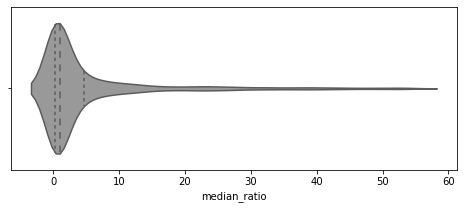

In [667]:
project__all_issues__time_to_close['median_ratio'] = (
    project__all_issues__time_to_close['median_gk'] / 
    project__all_issues__time_to_close['median_non_gk']
)
project__all_issues__time_to_close['mean_ratio'] = (
    project__all_issues__time_to_close['mean_gk'] / 
    project__all_issues__time_to_close['mean_non_gk']
)
for_plot = project__all_issues__time_to_close[['median_ratio']].copy()
# Remove outliers and extemes for plot
for_plot = for_plot[for_plot['median_ratio'] < 100]
for_plot = filter_outliers(for_plot, col='median_ratio', threshold=3)

for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=for_plot,
    x='median_ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
print('--Intra-project comparison for ratio of median time to close GK issues vs median time to close non-GK issues--')
tfns(project__all_issues__time_to_close, ['median_ratio', 'mean_ratio'])
plt.show()

<h3>Comparing distributions within same project</h3>

In [58]:
# non_gk_issues, gk_issues
non_gk_simplified = non_gk_issues[['id', 'repo_name', 'state', 'created_at', 'closed_at']].copy()
non_gk_simplified['time_to_close'] = non_gk_simplified['closed_at'] - non_gk_simplified['created_at']
non_gk_simplified['time_to_close_hours'] = non_gk_simplified['time_to_close'] / np.timedelta64(1, 'h')
non_gk_simplified['type'] = 'non_gk'
gk_simplified = gk_issues[['id', 'repo_name', 'state', 'created_at', 'closed_at']].copy()
gk_simplified['time_to_close'] = gk_simplified['closed_at'] - gk_simplified['created_at']
gk_simplified['time_to_close_hours'] = gk_simplified['time_to_close'] / np.timedelta64(1, 'h')
gk_simplified['type'] = 'gk'
combined = non_gk_simplified.append(gk_simplified)
combined_closed = combined[combined['state'] == 'closed']
combined_closed = combined_closed[combined_closed['time_to_close_hours'] != 0]
# combined_closed.info()
combined_closed['time_to_close_hours'].describe()

count    575448.000000
mean       1913.164198
std        4623.121705
min           0.000278
25%          12.971111
50%         148.851389
75%        1380.468542
max       82178.408889
Name: time_to_close_hours, dtype: float64

In [48]:
# combined_closed[combined_closed['time_to_close'] == pd.Timedelta(0)]
combined_closed['type'].describe()

count     980134
unique         2
top           gk
freq      490067
Name: type, dtype: object

In [95]:
def compare_project_distributions(project_issues):
    l_ngki = project_issues[project_issues['type'] == 'non_gk']
    l_gki = project_issues[project_issues['type'] == 'gk']
    project_issue_count = len(project_issues)
    project_ngki_count = len(l_ngki)
    project_gki_count = len(l_gki)
    x = l_ngki['time_to_close_hours']
    y = l_gki['time_to_close_hours']
    def create_return_obj(*args):
        return pd.Series([a for a in args])

    if len(x) == 0 or len(y) == 0:
        return create_return_obj(
            project_issue_count,
            project_ngki_count,
            project_gki_count,
            None,
            None,
            None,
            None
        )
    (statistic, pvalue) = mannwhitneyu(x, y)
    (delta, size) = cliffsDelta(x, y)
    return create_return_obj(
        project_issue_count,
        project_ngki_count,
        project_gki_count,
        statistic,
        pvalue,
        delta,
        size
    )
    
intra_project_distribution_compares = (
    combined_closed
        .groupby('repo_name')[['type', 'time_to_close_hours']]
        .apply(compare_project_distributions)
)

intra_project_distribution_compares.columns = [
    'project_issue_count',
    'project_ngki_count',
    'project_gki_count',
    'statistic',
    'pvalue',
    'delta',
    'size',
]
intra_project_distribution_compares = intra_project_distribution_compares.dropna().copy()
intra_project_distribution_compares['significant'] = intra_project_distribution_compares['pvalue'] < 0.05
intra_project_distribution_compares['size'] = intra_project_distribution_compares['size'].astype('category')

In [104]:
sig_and_size = (
    intra_project_distribution_compares[['significant', 'size']]
        .value_counts()
        .to_frame(name='count')
)
sig_and_size['proportion'] = sig_and_size['count'] / sig_and_size['count'].sum()
sig_and_size

count  proportion
significant size                         
False       large        2628    0.360494
            negligible   1280    0.175583
True        large        1263    0.173251
False       small         941    0.129081
            medium        828    0.113580
True        medium        244    0.033471
            small         100    0.013717
            negligible      6    0.000823

In [204]:
sig_and_size = (
    intra_project_distribution_compares
        .groupby(['size', 'significant'])
        .size()
        .unstack()
        .T
)

sig_and_size = sig_and_size[['large', 'medium', 'small', 'negligible']]
sig_and_size = sig_and_size.reindex([True, False])
sig_and_size_proportions = sig_and_size.applymap(lambda x: x / sig_and_size.sum().sum())

def make_label(x):
    label = f'{round(x * 100)}%'
    if label == '0%':
        label = '<1%'
    return label
        
sig_and_size_labels = sig_and_size_proportions.applymap(lambda x: make_label(x))


Saving figure time_to_close_project_distribution_significant_effect_size_table


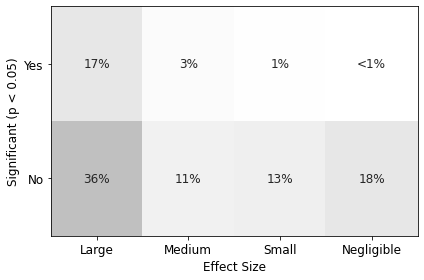

In [213]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

sns.heatmap(
    sig_and_size_proportions,
    annot=sig_and_size_labels,
    annot_kws={
        'fontsize': 12
    },
    fmt='',
    cbar=False,
    square=False,
    ax=ax,
    cmap=plt.get_cmap('Greys'),
    vmin=0,
    vmax=1,
)

ax.set_xlabel('Effect Size', fontsize=12)
ax.set_xticklabels(['Large', 'Medium', 'Small', 'Negligible'], rotation=0, fontsize=12)

ax.set_ylabel('Significant (p < 0.05)', fontsize=12)
ax.set_yticklabels(['Yes', 'No'], rotation=0, fontsize=12)

for _, spine in ax.spines.items():
    spine.set_visible(True)

    
save_fig('time_to_close_project_distribution_significant_effect_size_table')

plt.show()